In [1]:
import qutip as qt
import numpy as np

# Tracking info of simulations 
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

In [2]:
import model_building as md
import Hamiltonian as Ham
import dynamics as dyn
import data_handling as dh
import plots as plots


# PROTOCOL TEST

In [3]:
#Parameters

N=10
lmd = 0.02272
J = 0.5
state_dictionary = {"001":1}
state_dictionary = {"1":1}


ti = 0
tf = 150

Nsteps = 500

In [4]:

initial_state = md.crate_domain_wall_state(state_dictionary, register='Alice')
final_state   = md.crate_domain_wall_state(state_dictionary, register='Bob')

initial_chain = md.initialize_general_system(N, initial_state, register='Alice')
final_chain   = md.initialize_general_system(N, final_state, register='Bob')

In [5]:
#Create Hamiltonians
register_size = len(initial_state.dims[0])


H_transport = Ham.Hamiltonian(system_size = N,
                     mode = "forward",
                     lambda_factor = lmd,
                     global_J = J
                     )
H_reset     = Ham.Hamiltonian(system_size = N,
                     mode = "backward",
                     lambda_factor = lmd,
                     register_size = register_size,
                     global_J = J
                     )

In [6]:
#Algorithm

total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_chain, final_chain, H_transport, H_reset, ti, tf, Nsteps, AutoSwitch=True)

/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 514/514 [00:00<00:00, 4776.42it/s]


In [7]:
f_filename = dh.create_data_filename(N, J, lmd, state_dictionary, base_name='fidelity')
z_filename = dh.create_data_filename(N, J, lmd, state_dictionary, base_name='z_expectation')

f_data_directory = 'data_files/fidelity/'
z_data_directory = 'data_files/z_expectation/'

f_plot_directory = 'figures/fidelity/'
z_plot_directory = 'figures/z_expectation/' 


In [8]:
dh.save_numpy_array(total_full_fidelity, f'{f_data_directory}{f_filename}')
dh.save_numpy_array(magnetizations, f'{z_data_directory}{z_filename}')

In [ ]:
plots.plot_test_fidelity(total_full_fidelity, N, f'{f_plot_directory}{f_filename}')

In [ ]:
plots.plot_test_z_expectations(magnetizations, N, f'{z_plot_directory}{z_filename}')

# J VS LAMBDA TEST

In [3]:
def initialize_system(state_dictionary, N):
    initial_state = md.crate_domain_wall_state(state_dictionary, register='Alice')
    final_state   = md.crate_domain_wall_state(state_dictionary, register='Bob')

    initial_chain = md.initialize_general_system(N, initial_state, register='Alice')
    final_chain   = md.initialize_general_system(N, final_state, register='Bob')

    register_size = len(initial_state.dims[0])
    
    return initial_chain, final_chain, register_size

def build_hamiltonians(N, lmd, J, reg_size):

    H_transport = Ham.Hamiltonian(system_size = N,
                        mode = "forward",
                        lambda_factor = lmd,
                        global_J = J
                        )
    H_reset     = Ham.Hamiltonian(system_size = N,
                        mode = "backward",
                        lambda_factor = lmd,
                        register_size = reg_size,
                        global_J = J
                        )
    
    return H_transport, H_reset


def calculate_logs(x_data, y_data):
    log_axis = [np.log(i) for i in x_data]
    log_error = [np.log(1-i) for i in y_data]
    return log_axis, log_error

In [52]:
#Constant simulation parameters
N = 9
lmd = 0.02272
ti = 0
tf = 150
step_number = 500

ratios = range(1,21) # will be used to calculate J accordingly


# Generate initial and target statess
state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}
# state_dictionary = {"111":1, "000":1}

initial_system, final_system, register_size = initialize_system(state_dictionary, N)
maximum_fidelities = []

for ratio in ratios:
    print(ratio)
    J = ratio*lmd
    H_transport, H_reset = build_hamiltonians(N, lmd, J, register_size)
    total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_system, final_system, H_transport, H_reset, ti, tf, step_number, AutoSwitch=True)
    maximum_fidelities.append(max(total_full_fidelity))

1


100%|██████████| 557/557 [00:00<00:00, 31461.80it/s]


2


100%|██████████| 557/557 [00:00<00:00, 26974.73it/s]


3


100%|██████████| 526/526 [00:00<00:00, 26707.23it/s]


4


100%|██████████| 524/524 [00:00<00:00, 24272.65it/s]


5


100%|██████████| 522/522 [00:00<00:00, 21948.48it/s]


6


100%|██████████| 519/519 [00:00<00:00, 19803.17it/s]


7


100%|██████████| 517/517 [00:00<00:00, 17745.13it/s]


8


100%|██████████| 516/516 [00:00<00:00, 17313.12it/s]


9


100%|██████████| 515/515 [00:00<00:00, 12651.13it/s]


10


100%|██████████| 515/515 [00:00<00:00, 12902.78it/s]


11


100%|██████████| 515/515 [00:00<00:00, 15197.50it/s]


12


100%|██████████| 515/515 [00:00<00:00, 14110.80it/s]


13


100%|██████████| 514/514 [00:00<00:00, 13337.49it/s]


14


100%|██████████| 514/514 [00:00<00:00, 13059.96it/s]


15


100%|██████████| 514/514 [00:00<00:00, 12151.24it/s]

16

100%|██████████| 514/514 [00:00<00:00, 11780.40it/s]


17


100%|██████████| 514/514 [00:00<00:00, 10820.86it/s]


18


100%|██████████| 514/514 [00:00<00:00, 7839.08it/s]


19


100%|██████████| 514/514 [00:00<00:00, 10109.13it/s]


20


100%|██████████| 514/514 [00:00<00:00, 5534.08it/s]


In [53]:
ratio_filename = dh.create_data_filename(N, f'{ratios[-1]}', lmd, state_dictionary, 'ratio')
dh.save_plot_data_to_csv(ratios, maximum_fidelities, f'data_files/ratios/{ratio_filename}')

Data saved to data_files/ratios/ratio_N9_J20_L0.023_1_1_20250917_120238
First 5 rows:
Time_step	Fidelity
1.0000	0.1892
2.0000	0.5981
3.0000	0.8026
4.0000	0.8585
5.0000	0.9239


In [54]:
ratios_1, values_1, recovered_filename = dh.read_plot_data_from_csv(f"data_files/ratios/{ratio_filename}.csv")

log_ratios_1, log_errors_1 = calculate_logs(ratios_1, values_1)

In [55]:
#Plot data the right way, -D 
#Compute for all data. -D
#Plot all data together
#Test with N = 9 -D

<Figure size 2400x1800 with 0 Axes>

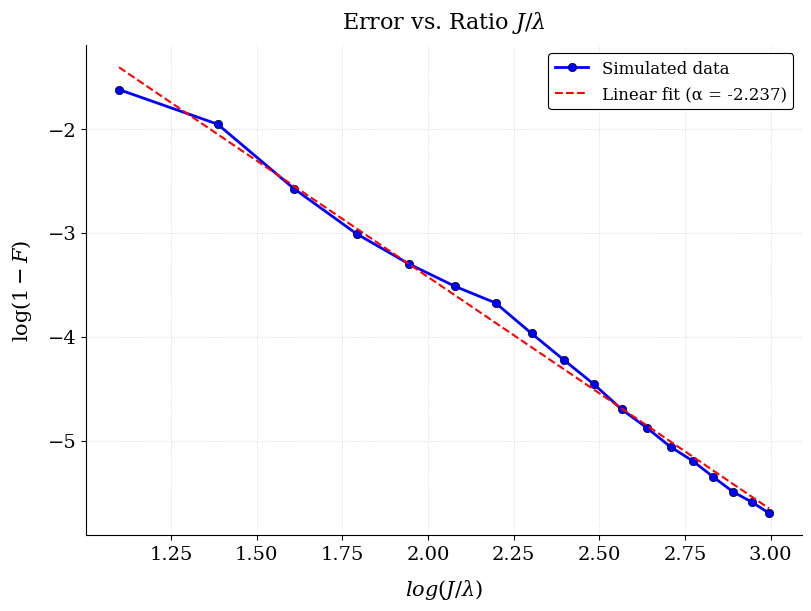

In [56]:
plots.plot_ratios_trend_slope(x_data=log_ratios_1[2:], y_data=log_errors_1[2:],log_scale=False, filepath=f'figures/ratios/{recovered_filename}')

# J VS LAMBDA MAIN CALCULATION

In [4]:
#Constant simulation parameters
N = 9
lmd = 0.02272
ti = 0
tf = 150
step_number = 500

ratios = range(1,21) # will be used to calculate J accordingly


# Generate initial and target statess
# state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}
# state_dictionary = {"111":1, "000":1}

state_dictionaries = [{"1":1}, {"1":1, "0":1}, {"11":1, "00":1}, {"111":1, "000":1}]
filenames = []
for dictionary in state_dictionaries:

    initial_system, final_system, register_size = initialize_system(dictionary, N)
    maximum_fidelities = []

    for ratio in ratios:
        print(ratio)
        J = ratio*lmd
        H_transport, H_reset = build_hamiltonians(N, lmd, J, register_size)
        total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_system, final_system, H_transport, H_reset, 
                                                                   ti, tf, step_number, AutoSwitch=True)
        maximum_fidelities.append(max(total_full_fidelity))

    ratio_filename = dh.create_data_filename(N, f'{ratios[-1]}', lmd, dictionary, 'ratio')
    dh.save_plot_data_to_csv(ratios, maximum_fidelities, f'data_files/ratios/{ratio_filename}')
    filenames.append(ratio_filename)

/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1


100%|██████████| 557/557 [00:00<00:00, 30437.06it/s]


2


100%|██████████| 557/557 [00:00<00:00, 27925.59it/s]


3


100%|██████████| 526/526 [00:00<00:00, 25927.89it/s]


4


100%|██████████| 524/524 [00:00<00:00, 23834.37it/s]


5


100%|██████████| 522/522 [00:00<00:00, 21772.77it/s]


6


100%|██████████| 519/519 [00:00<00:00, 19676.26it/s]


7


100%|██████████| 517/517 [00:00<00:00, 18670.40it/s]


8


100%|██████████| 516/516 [00:00<00:00, 17273.74it/s]


9


100%|██████████| 515/515 [00:00<00:00, 16547.29it/s]


10


100%|██████████| 515/515 [00:00<00:00, 15304.10it/s]


11


100%|██████████| 515/515 [00:00<00:00, 14482.12it/s]


12


100%|██████████| 515/515 [00:00<00:00, 13776.37it/s]


13


100%|██████████| 514/514 [00:00<00:00, 13227.67it/s]


14


100%|██████████| 514/514 [00:00<00:00, 12209.87it/s]


15


100%|██████████| 514/514 [00:00<00:00, 11676.78it/s]


16


100%|██████████| 514/514 [00:00<00:00, 11592.21it/s]


17


100%|██████████| 514/514 [00:00<00:00, 11312.82it/s]


18


100%|██████████| 514/514 [00:00<00:00, 8004.49it/s]


19


100%|██████████| 514/514 [00:00<00:00, 10183.48it/s]


20


100%|██████████| 514/514 [00:00<00:00, 10004.09it/s]


Data saved to data_files/ratios/ratio_N9_J20_L0.023_1_1_20250917_121624
First 5 rows:
Time_step	Fidelity
1.0000	0.1892
2.0000	0.5981
3.0000	0.8026
4.0000	0.8585
5.0000	0.9239
1


100%|██████████| 557/557 [00:00<00:00, 29833.83it/s]


2


100%|██████████| 557/557 [00:00<00:00, 26115.94it/s]


3


100%|██████████| 529/529 [00:00<00:00, 24350.70it/s]


4


100%|██████████| 531/531 [00:00<00:00, 21090.68it/s]


5


100%|██████████| 528/528 [00:00<00:00, 20807.97it/s]


6


100%|██████████| 511/511 [00:00<00:00, 9398.70it/s]


7


100%|██████████| 510/510 [00:00<00:00, 17832.33it/s]


8


100%|██████████| 510/510 [00:00<00:00, 17063.07it/s]


9


100%|██████████| 510/510 [00:00<00:00, 15190.28it/s]


10


100%|██████████| 511/511 [00:00<00:00, 14259.70it/s]


11


100%|██████████| 511/511 [00:00<00:00, 13184.04it/s]


12


100%|██████████| 511/511 [00:00<00:00, 12506.14it/s]

13

100%|██████████| 513/513 [00:00<00:00, 12213.71it/s]


14


100%|██████████| 513/513 [00:00<00:00, 11141.32it/s]


15


100%|██████████| 513/513 [00:00<00:00, 10200.62it/s]


16


100%|██████████| 513/513 [00:00<00:00, 10052.97it/s]


17


100%|██████████| 513/513 [00:00<00:00, 9506.86it/s]


18


100%|██████████| 513/513 [00:00<00:00, 8808.53it/s]


19


100%|██████████| 513/513 [00:00<00:00, 8603.65it/s]


20


100%|██████████| 513/513 [00:00<00:00, 8438.45it/s]


Data saved to data_files/ratios/ratio_N9_J20_L0.023_1_1_0_1_20250917_121628
First 5 rows:
Time_step	Fidelity
1.0000	0.5000
2.0000	0.5000
3.0000	0.8080
4.0000	0.8826
5.0000	0.9172
1


100%|██████████| 557/557 [00:00<00:00, 30094.78it/s]


2


100%|██████████| 448/448 [00:00<00:00, 28957.44it/s]


3


100%|██████████| 498/498 [00:00<00:00, 25109.55it/s]


4


100%|██████████| 513/513 [00:00<00:00, 24215.06it/s]


5


100%|██████████| 518/518 [00:00<00:00, 22080.44it/s]


6


100%|██████████| 520/520 [00:00<00:00, 20339.43it/s]


7


100%|██████████| 522/522 [00:00<00:00, 19088.45it/s]


8


100%|██████████| 522/522 [00:00<00:00, 17709.22it/s]


9


100%|██████████| 522/522 [00:00<00:00, 15829.74it/s]


10


100%|██████████| 522/522 [00:00<00:00, 14433.85it/s]


11


100%|██████████| 498/498 [00:00<00:00, 13542.21it/s]


12


100%|██████████| 499/499 [00:00<00:00, 13931.50it/s]


13


100%|██████████| 520/520 [00:00<00:00, 11808.29it/s]

14

100%|██████████| 520/520 [00:00<00:00, 11095.48it/s]


15


100%|██████████| 503/503 [00:00<00:00, 10373.52it/s]


16


100%|██████████| 504/504 [00:00<00:00, 10195.37it/s]


17


100%|██████████| 519/519 [00:00<00:00, 10888.25it/s]


18


100%|██████████| 519/519 [00:00<00:00, 9355.89it/s]


19


100%|██████████| 519/519 [00:00<00:00, 9134.77it/s]


20


100%|██████████| 506/506 [00:00<00:00, 8993.14it/s]


Data saved to data_files/ratios/ratio_N9_J20_L0.023_11_1_00_1_20250917_121631
First 5 rows:
Time_step	Fidelity
1.0000	0.5000
2.0000	0.5652
3.0000	0.8635
4.0000	0.9339
5.0000	0.9604
1


100%|██████████| 557/557 [00:00<00:00, 32768.46it/s]


2


100%|██████████| 557/557 [00:00<00:00, 29784.76it/s]


3


100%|██████████| 510/510 [00:00<00:00, 27205.60it/s]


4


100%|██████████| 517/517 [00:00<00:00, 23922.77it/s]


5


100%|██████████| 518/518 [00:00<00:00, 22821.23it/s]


6


100%|██████████| 519/519 [00:00<00:00, 20414.55it/s]


7


100%|██████████| 519/519 [00:00<00:00, 17387.49it/s]


8


100%|██████████| 518/518 [00:00<00:00, 17390.10it/s]


9


100%|██████████| 518/518 [00:00<00:00, 15301.43it/s]


10


100%|██████████| 518/518 [00:00<00:00, 14834.73it/s]


11


100%|██████████| 518/518 [00:00<00:00, 14712.47it/s]


12


100%|██████████| 519/519 [00:00<00:00, 13763.29it/s]


13


100%|██████████| 520/520 [00:00<00:00, 13894.53it/s]


14


100%|██████████| 520/520 [00:00<00:00, 12840.44it/s]


15


100%|██████████| 522/522 [00:00<00:00, 11251.25it/s]


16


100%|██████████| 520/520 [00:00<00:00, 12025.35it/s]


17


100%|██████████| 518/518 [00:00<00:00, 10673.58it/s]


18


100%|██████████| 517/517 [00:00<00:00, 9861.32it/s]


19


100%|██████████| 517/517 [00:00<00:00, 10392.29it/s]


20


100%|██████████| 517/517 [00:00<00:00, 9788.10it/s]

Data saved to data_files/ratios/ratio_N9_J20_L0.023_111_1_000_1_20250917_121635
First 5 rows:
Time_step	Fidelity
1.0000	0.5000
2.0000	0.5000
3.0000	0.7593
4.0000	0.8751
5.0000	0.9153


In [5]:
ratios_1,    values_1,    recovered_filename = dh.read_plot_data_from_csv(f"data_files/ratios/{filenames[0]}.csv")
ratios_plus, values_plus, recovered_filename = dh.read_plot_data_from_csv(f"data_files/ratios/{filenames[1]}.csv")
ratios_bell, values_bell, recovered_filename = dh.read_plot_data_from_csv(f"data_files/ratios/{filenames[2]}.csv")
ratios_ghz,  values_ghz,  recovered_filename = dh.read_plot_data_from_csv(f"data_files/ratios/{filenames[3]}.csv")

log_ratios_1,    log_errors_1    =  calculate_logs(ratios_1, values_1)
log_ratios_plus, log_errors_plus =  calculate_logs(ratios_plus, values_plus)
log_ratios_bell, log_errors_bell =  calculate_logs(ratios_bell, values_bell)
log_ratios_ghz,  log_errors_ghz  =  calculate_logs(ratios_ghz, values_ghz)